# Detection Malicious URL Using ML Models

In [ ]:
pip install tld

<a id="1"></a> <br>
# 📥 Importing Libraries

In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld

<a id="2"></a> <br>
# 🗃️ Load Dataset

In [ ]:
data = pd.read_csv('/content/malicious_phish.csv')
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


<a id="3"></a> <br>
# 📝 Meta information of Dataframe

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


<a id="4"></a>
# 🔎 Checking for NaN values

In [ ]:
data.isnull().sum()

url     0
type    0
dtype: int64

In [ ]:
count = data.type.value_counts()
count

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

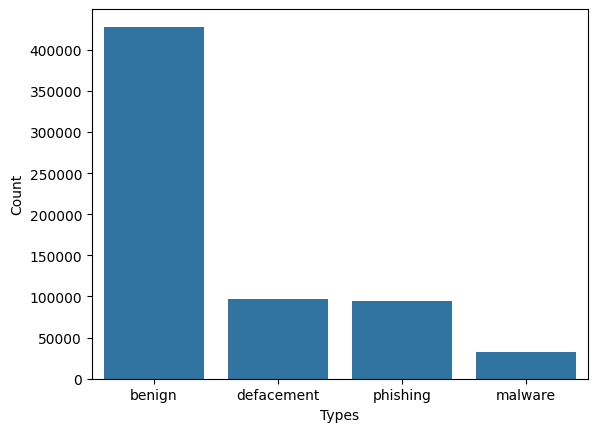

In [ ]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');

<h4>first have to omit the (www.) from the URL which is in fact a sub domain in itself.</h4>

In [ ]:
data['url'] = data['url'].replace('www.', '', regex=True)
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [ ]:
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
data['Category'] = data['type']
data = data.replace(rem)

<a id="5"></a> <br>
# 🦾 Feature Extraction

In [ ]:
data['url_len'] = data['url'].apply(lambda x: len(str(x)))

In [ ]:
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [ ]:
data['domain'] = data['url'].apply(lambda i: process_tld(i))

In [ ]:
data.head()

,url,type,Category,url_len,domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


In [ ]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))

In [ ]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [ ]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [ ]:
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

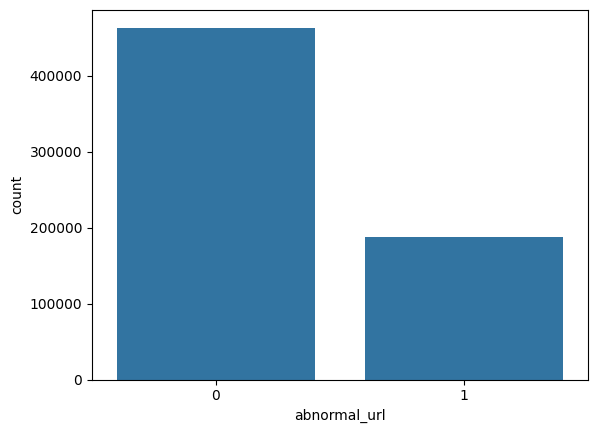

In [ ]:
sns.countplot(x='abnormal_url', data=data);

In [ ]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [ ]:
data['https'] = data['url'].apply(lambda i: httpSecure(i))

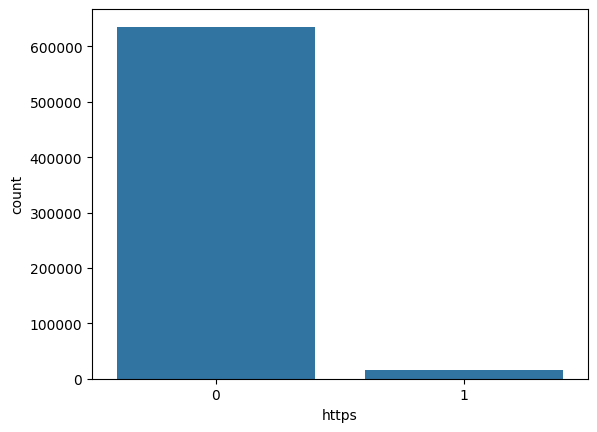

In [ ]:
sns.countplot(x='https', data=data);

<h4>Counts the number of digit characters in a URL</h4>

In [ ]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [ ]:
data['digits']= data['url'].apply(lambda i: digit_count(i))

<h4>Counts the number of letter characters in a URL</h4>

In [ ]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [ ]:
data['letters']= data['url'].apply(lambda i: letter_count(i))

<h4>Checks to see whether URL contains a shortening service</h4>

In [ ]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [ ]:
data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))

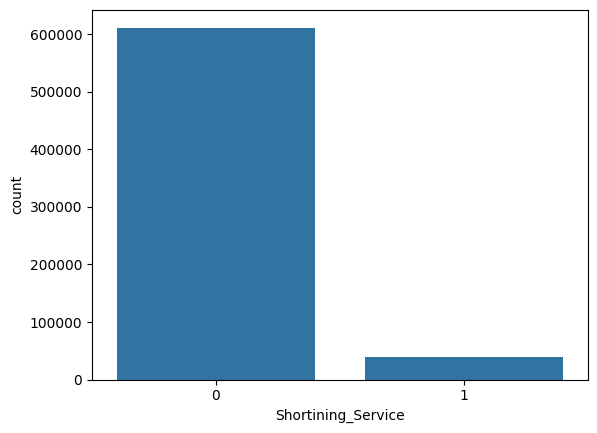

In [ ]:
sns.countplot(x='Shortining_Service', data=data);

In [ ]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [ ]:
data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))

In [ ]:
data['having_ip_address'].value_counts()

0    638703
1     12488
Name: having_ip_address, dtype: int64

<ipython-input-33-d14f9601ff3f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), linewidths=.5)


<Axes: >

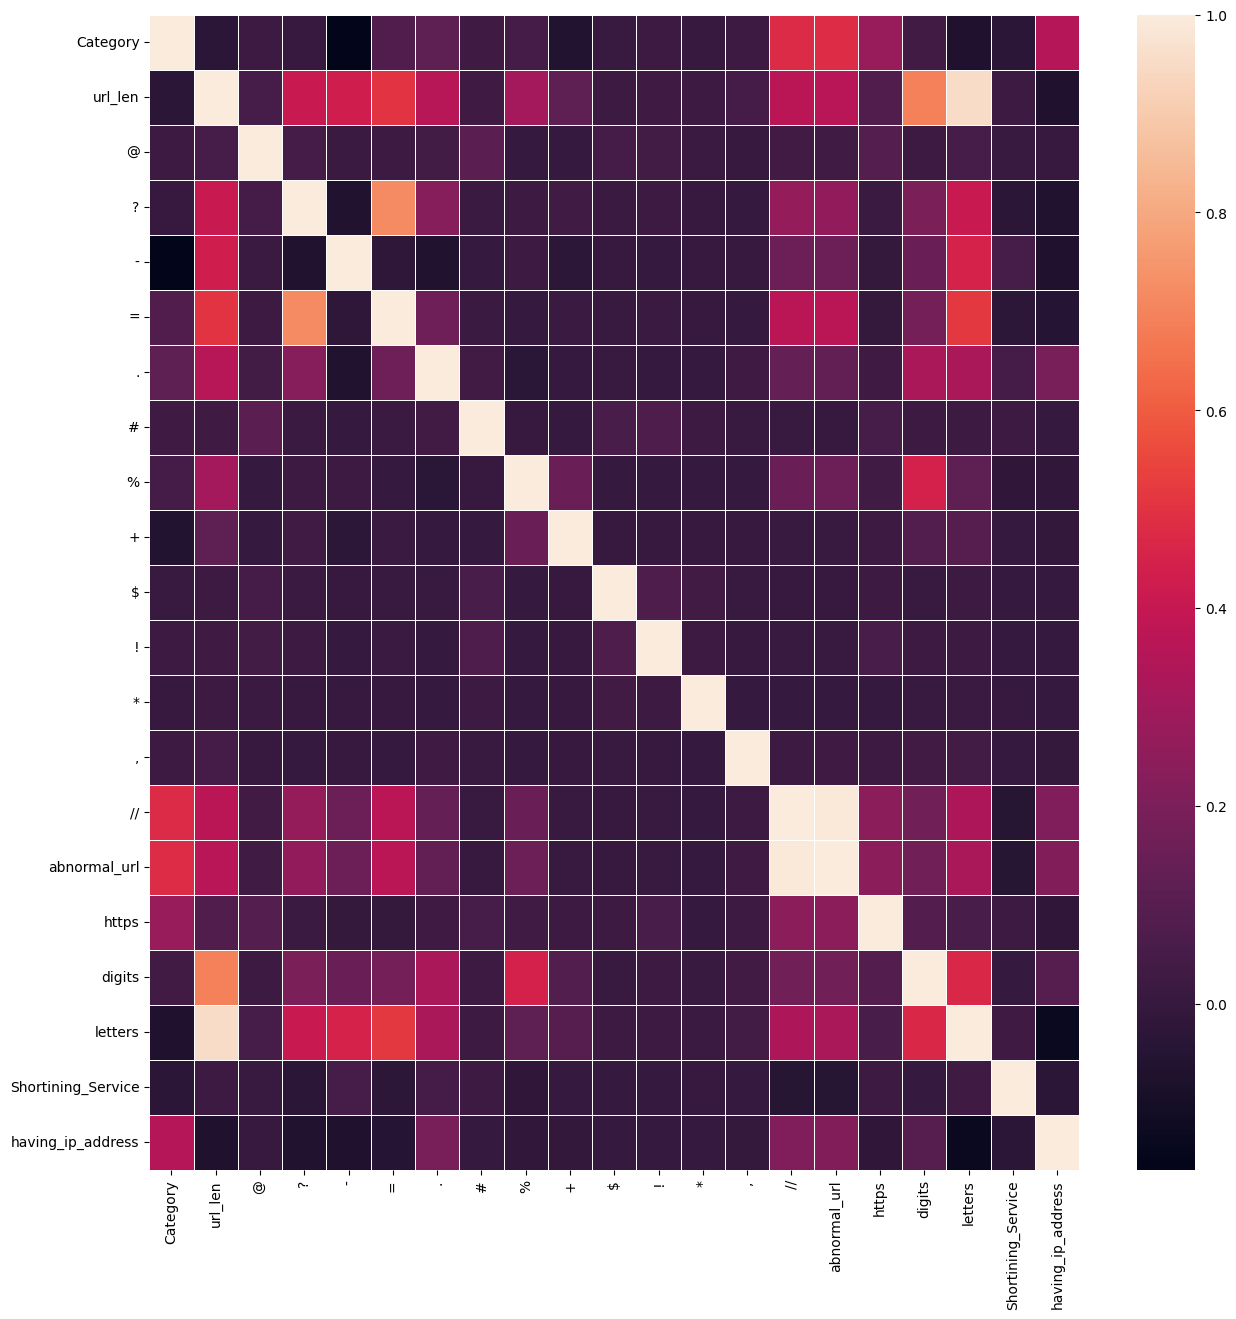

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), linewidths=.5)

In [ ]:
X = data[['url', 'type', 'Category', 'domain']]
y = data['Category']

<a id="6"></a> <br>
# ✂️ Train & Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_train

,url,type,Category,domain
298498,archiver.rootsweb.ancestry.com/th/read/QBC-MON...,benign,0,archiver.rootsweb.ancestry.com
248931,city-data.com/city/St.-Louis-Park-Minnesota.html,benign,0,city-data.com
416710,pelikulaatbp.blogspot.com/,benign,0,pelikulaatbp.blogspot.com
521488,http://decifra.com.br/at&amp;t-mail/ATT/6533d9...,phishing,2,decifra.com.br
572272,profilefoodingredients.com/oldsite/images/payp...,benign,0,profilefoodingredients.com
...,...,...,...,...
448326,billystrangemusic.com/,benign,0,billystrangemusic.com
409891,biographi.ca/009004-119.01-e.php?&id_nbr=1354&...,benign,0,biographi.ca
481837,http://earthmatterslaw.org/properties/index.htm,phishing,2,earthmatterslaw.org
271300,twinspack.com,phishing,2,twinspack.com


In [ ]:
y_train

298498    0
248931    0
416710    0
521488    2
572272    0
         ..
448326    0
409891    0
481837    2
271300    2
418551    0
Name: Category, Length: 520952, dtype: int64

<a id="7"></a> <br>
# <img src="https://cdn-icons-png.flaticon.com/32/4149/4149680.png"/> Training models

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Assuming 'data' contains your dataset

# Extract features and target variable
X = data[['url', 'type', 'domain']].copy()
y = data['Category']

# Label encode non-numeric features
label_encoder = LabelEncoder()
X['url'] = label_encoder.fit_transform(X['url'])
X['type'] = label_encoder.fit_transform(X['type'])
X['domain'] = label_encoder.fit_transform(X['domain'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
random_forest_model = RandomForestClassifier(max_depth=42, random_state=42)

# Train the model on the training data
random_forest_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = random_forest_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 100.00%


<a id="8"></a> <br>
# <img src="https://cdn-icons-png.flaticon.com/64/3094/3094836.png"/> Final Report

In [ ]:
output = pd.DataFrame({"Model":['Random Forest Classifier'],
                      "Accuracy":accuracy})

In [ ]:
output

,Model,Accuracy
0,Random Forest Classifier,1.0


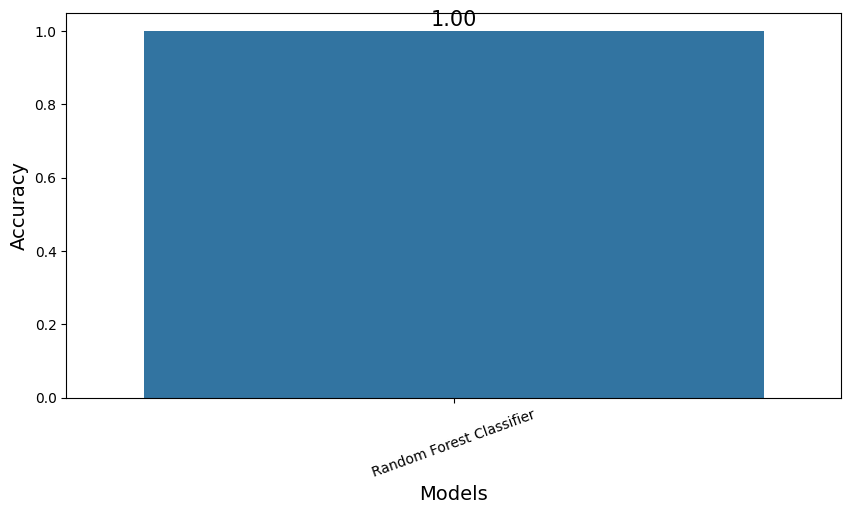

In [ ]:
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=20);
plt.ylabel("Accuracy", size=14)
plt.show()

<a id="9"></a> <br>
# ✨ Thanks

* Feel free to download Notebook and do experiments on it.
* Comments if you find something inappropriate and will improve accordingly.
* Upvote if you find this notebook useful.